# Linear Regression

In this notebook we study the basics of *linear regression* with Octave. In this study we are interested in the algorithms and their implementation, so what touches exploratory data analysis and selection of predictors might seem a raw, but this is implicit by the main objective of this notebook. Here we make use of Boston housing prices data set to study linear regression. 

## Loading and inspecting data

Start by loading the Boston housing price dataset and check available variables.

In [1]:
data = csvread('../datasets/boston.csv');
whos

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        ans         1x5                          5  char
        data      507x14                     56784  double

Total is 7103 elements using 56789 bytes



Split predictors from target data by column indices. Select feature 6 (RM), the number of rooms as predictor for simple linear regression and feature 11 (PTRATIO) together with the previous for multivariate regression. These features have been chosen because they presents a good correlation with the target variable, what is fine for out didatic purposes here. For slicing the array, please notice that Octave fills the first row with zeros, thus we should skip it.

In [2]:
X = data(2:end, 1:13);
y = data(2:end, 14);

%  Select predictor feature.
X_pred1 = X(:, 6);
X_pred2 = X(:, [6, 11]);

Visualize the relationship between predictor and target data.

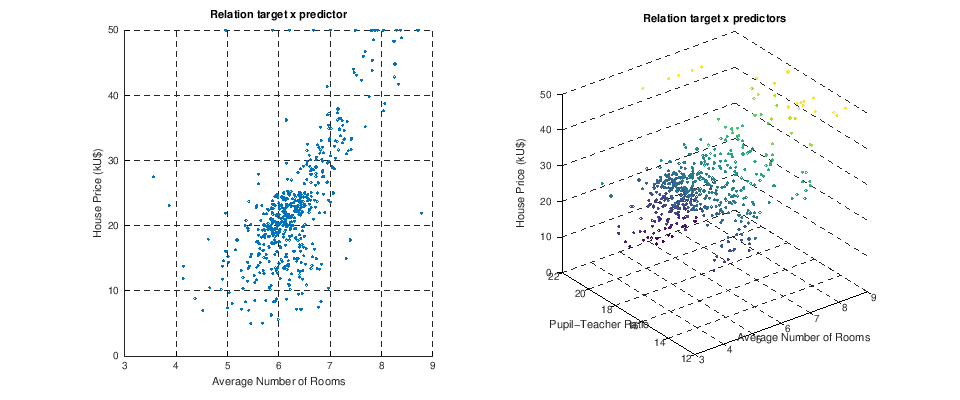

In [3]:
%plot inline -r 100 -w 960 -h 400

subplot(1, 2, 1);
scatter(X_pred1, y);
title('Relation target x predictor');
xlabel('Average Number of Rooms');
ylabel('House Price (kU$)');
grid on;
set(gca, 'GridLineStyle', '--');

subplot(1, 2, 2);
scatter3(X_pred2(:, 1), X_pred2(:, 2), y, [], y(:), 'o');
title('Relation target x predictors');
xlabel('Average Number of Rooms');
ylabel('Pupil-Teacher Ratio');
zlabel('House Price (kU$)');
grid on;
set(gca, 'GridLineStyle', '--');

## Model fundamentals

A linear regression is a linear model that produces the output by computing a weighted sum of its inputs. Using matrix form we have the hypothesis $\mathbf{h}$ to be given as $\mathbf{h}_{\mathbf{\theta}}(\mathbf{X})=\mathbf{X}^{T}\mathbf{\theta}$, where $\mathbf{\theta}$ is the vector of model parameters and $\mathbf{X}$ are the model features. The model features are given by

$$
\mathbf{X}=\begin{bmatrix}x_{0} & x_{1} & \dots & x_{n}\end{bmatrix}^T\in \mathcal{R}^{n+1}
$$

where by definition $x_{0}\equiv{}\mathbf{1}$, providing the multiplier to the *linear intercept*, *i.e.* the value the model assumes under the case the weighted sum of other parameters is identically null, with the trivial case being given by all null input features. The same can be written for the parameters as

$$
\mathbf{\theta}=\begin{bmatrix}\theta_{0} & \theta_{1} & \dots & \theta_{n}\end{bmatrix}^T\in \mathcal{R}^{n+1}
$$

where $\theta_{0}$ is the linear intercept. The function `hypothesis` computes the linear model as exposed above.

In [4]:
function [predictions] = hypothesis(X, theta)
    % HYPOTHESIS Compute model with parameters.
    %   predictions = hypothesis(X, theta)
    %
    %   Inputs:
    %     X - input features - (m x n) matrix.
    %     theta - model parameters - (n x 1) vector.
    %
    %   Output:
    %     predictions - evaluated model - (m x 1) vector.
    %
    %   Where:
    %     m - number of training examples.
    %     n - number of features.
    predictions = X * theta;
end

### Normal equation and cost function

Given a known dataset with features $\mathbf{X}$ and ouputs $\mathbf{y}$, a procedure has to be established for computing $\mathbf{\theta}$. Notice that in the general case $\mathbf{X}$ can be singular and an inverse cannot be ensured. Furthermore, computing the inverse can be expensive for really large datasets ($n>10000$ features). The general solution to the problem is given by the so called *normal equation* $\mathbf{\theta}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$, where $(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$ is the *pseudo-inverse* of $\mathbf{X}$. An implementation for this method is provided by function `normal_equation`.

In [5]:
function [theta] = normal_equation(X, y)
    % NORMAL EQUATION Solve X theta = y for theta.
    %   theta = normal_equation(X, y)
    theta = pinv(X' * X) * X' * y;
end

The *normal equation* is in fact the analytical solution of the minimization of *cost function* $J(\mathbf{\theta})$ that computes the mean square error of the predictions, *i.e.* $J(\mathbf{\theta})=\frac{1}{2m}\lVert\mathbf{e}\rVert^2=\frac{1}{2m}\lVert\mathbf{y}-\mathbf{h}_{\mathbf{\theta}}(\mathbf{X})\rVert^2$. Thus $\hat{\mathbf{\theta}}=\arg \max_{\theta}J(\mathbf{\theta})$. Expanding $J(\mathbf{\theta})$ and taking its derivative with respect to $\mathbf{\theta}$:

$$
\dfrac{\partial{}J(\mathbf{\theta})}{\partial\mathbf{\theta}}=-\mathbf{X}^{T}\mathbf{y}+\mathbf{X}^{T}\mathbf{X}\mathbf{\theta}
$$

Setting this equation to $\mathbf{0}$ and solving for $\mathbf{\theta}$ produces the normal equation. Since this might be computationally expensive in some cases, a `cost_function` is provided for numerical optimization of the problem in what follows.

In [6]:
function [cost] = cost_function(X, y, theta)
    % COST_FUNCTION Compute model accuracy based on parameters.
    %   cost = cost_function(X, y, theta, lambda)
    %   
    %   Inputs:
    %     X - input features - (m x n) matrix.
    %     y - a vector of correct output - (m x 1) vector.
    %     theta - our model parameters - (n x 1) vector.
    %
    %   Output:
    %     cost - error of model with specified parameters.
    %
    %   Where:
    %     m - number of training examples.
    %     n - number of features.
    m = size(X, 1);

    % Errors between predictions and correct output values.
    errors = y - hypothesis(X, theta);

    % Calculate current predictions cost.
    cost = (1 / (2 * m)) * (errors' * errors);
end

### Gradient descent

*Gradient Descent (GD)* is an iterative optimization algorithm for finding the minimum of a cost function. Given an initial estimate of $\mathbf{\theta}$, the algorithm corrects theta at small steps $-\alpha\nabla{}J(\theta)$ (to avoid overshooting and divergence), *i.e.* following the path that minimizes the cost function. The value $\alpha$ is called the *learning rate* of the algorithm. 

$$
\theta_{j} := \theta_{j}-\alpha\frac{1}{m}\sum_{1}^{m}(y^{(i)}-h_{\mathbf{\theta}}(x^{(i)}))x_{j}^{(i)}
$$

Function `gradient_descent` implements the optimization of $\theta$.

In [7]:
function [theta, J_history] = gradient_descent(X, y, theta, alpha, n_iters)
    % GRADIENT_STEP Perform gradient descent to minimize cost function.
    %   [theta, J_history] = gradient_descent(X, y, theta, alpha, lambda, n_iters)
    %
    %   Input:
    %     X - training set of features - (m x n) matrix.
    %     y - a vector of expected output values - (m x 1) vector.
    %     theta - current model parameters - (n x 1) vector.
    %     alpha - gradient descent learning rate.
    %     n_iters - number of steps in gradient descent.
    %
    %   Output:
    %     theta - optimized theta parameters - (m x 1) vector.
    %     J_history - the history cost function changes over iterations.
    %
    %   Where:
    %     m - number of training examples.
    %     n - number of features.
    m = size(X, 1);
    J_history = zeros(n_iters, 1);
    for num = 1:n_iters
        % Errors between predictions and correct output values.
        errors = hypothesis(X, theta) - y;

        % Vectorized version of gradient descent.
        theta = theta - (alpha / m) * (errors' * X)';

        % Keep history of cost function.
        J_history(num) = cost_function(X, y, theta);
    end
end

### Linear regression

Finally, to optimize $\theta$ the function `linear_regression` is conceived. This function manages the initialization of the problem and then makes use of `gradient_descent` to find the model parameters. Notice that a column of ones is added as $x_{0}$ in the parameters matrix, taking into account the linear intercept.

In [8]:
function [X] = make_pars(X)
    % MAKE_PARS Add ones column to parameters.
    %  [X] = make_pars(X)
    %   Input:
    %     X - training set of features - (m x n) matrix.
    %
    %   Output:
    %     X - training set of features - (m x (n + 1)) matrix.
    %
    %   Where:
    %     m - number of training examples.
    m = size(X, 1);

    % Add a column of ones to X.
    X = [ones(m, 1), X];
end

In [9]:
function [theta, J_history] = linear_regression(X, y, alpha, n_iters)
    % LINEAR_REGRESSION Perform GD linear regression.
    %   [theta, J_history] = linear_regression(X, y, theta, alpha, lambda, n_iters)
    %
    %   Input:
    %     X - training set of features - (m x n) matrix.
    %     y - a vector of expected output values - (m x 1) vector.
    %     alpha - gradient descent learning rate.
    %     n_iters - number of steps in gradient descent.
    %
    %   Output:
    %     theta - optimized theta parameters - (m x 1) vector.
    %     J_history - the history cost function changes over iterations.
    %
    %   Where:
    %     m - number of training examples.
    %     n - number of features.
    [m n] = size(X);

    % Add a column of ones to X.
    X = make_pars(X);

    % Initialize model parameters.
    theta0 = zeros(n + 1, 1);

    % Run gradient descent.
    [theta, J_history] = gradient_descent(X, y, theta0, alpha, n_iters);
end

### Feature scaling

In some cases the algorithm may fail to converge. This can be due to an excessively high learning rate $\alpha$ or scale factors in features, specially in multivariate cases. It is good practice to keep the inputs absolute value in a range close to unity. Several methods are available for scaling the parameters respecting this practice. Here we will make use of standard normalization as given by `std_scaler`. This function subtracts the mean of data from features (ensuring a mean close to zero) and divide the result by the standard deviations (producing a unity variance for each feature). When using a model with scaled inputs on new datasets, one must use the computed mean and standard deviation data from the training set to properly scale the inputs.

In [10]:
function [Z, mu, sigma] = std_scaler(X)
    % STD_SCALER Apply standard scaling to matrix.
    %   Z = std_scaler(X) computes the scaled version of X.
    Z = X;
    mu = mean(X);
    sigma = std(X);
    Z = (X - mu) ./ sigma;
end

## Univariate application

Next we fit the linear regression without feature scaling. Observe that for the learning rate and number of iterations the numerical method does not converge to the normal equation analytical solution.

In [11]:
%plot inline -r 100 -w 960 -h 360

function view(X, y, y_pred, y_norm, J_history)
    % VIEW Helper function for visualizing results.
    subplot(1, 2, 1);
    plot(X, y_pred, 'k');
    hold on;
    plot(X, y_norm, 'b');
    hold on;
    scatter(X, y, 'r');
    title('Relation target x predictor');
    xlabel('Average Number of Rooms');
    ylabel('House Price (kU$)');
    grid on;
    set(gca, 'GridLineStyle', '--');
    legend('numerical', 'analytical');

    subplot(1, 2, 2);
    plot(1:size(J_history, 1), J_history);
    title('Gradient Descent Progress');
    xlabel('Iteration');
    ylabel('J(\theta)');
    grid on;
    set(gca, 'GridLineStyle', '--');
end

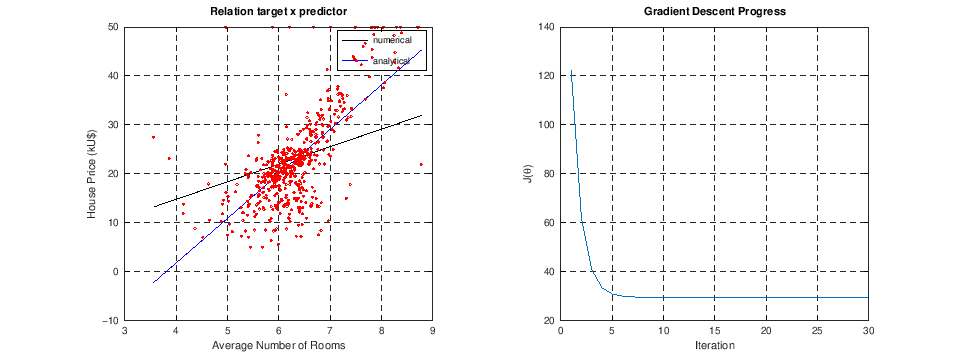

In [12]:
alpha = 0.01;
n_iters = 30;
[theta, J_history] = linear_regression(X_pred1, y, alpha, n_iters);

X_hyps = make_pars(X_pred1);
y_pred = hypothesis(X_hyps, theta);

theta_norm = normal_equation(X_hyps, y);
y_norm = hypothesis(X_hyps, theta_norm);

view(X_pred1, y, y_pred, y_norm, J_history);

To solve the convergence problem, we apply feature scaling before training the model. Notice that the convergence rate in this case is slower and we must increase the number of iterations, but in the end the prediction closely matches the normal equation solution to the problem.

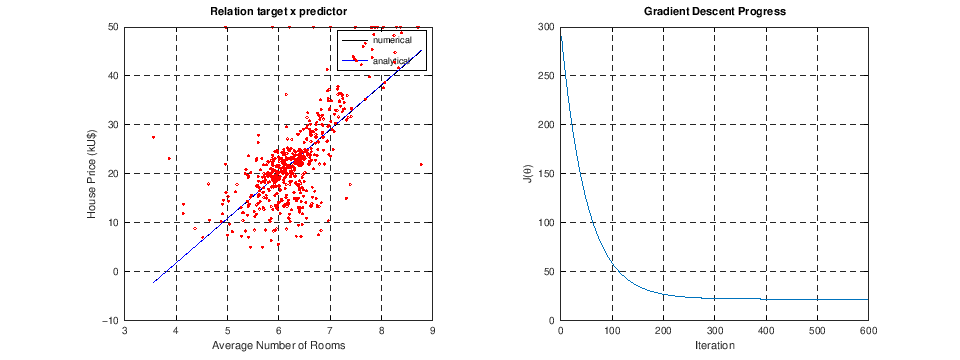

In [13]:
alpha = 0.01;
n_iters = 600;
X_norm = std_scaler(X_pred1);
[theta, J_history] = linear_regression(X_norm, y, alpha, n_iters);

X_hyps = make_pars(X_norm);
y_pred = hypothesis(X_hyps, theta);

theta_norm = normal_equation(X_hyps, y);
y_norm = hypothesis(X_hyps, theta_norm);

view(X_pred1, y, y_pred, y_norm, J_history);

## Multivariate application

To conclude, we fit the model with two features. Notice here that computation of the model values was done manually for simplicity.

In [14]:
alpha = 0.01;
n_iters = 600;
X_norm = std_scaler(X_pred2);
[theta, J_history] = linear_regression(X_norm, y, alpha, n_iters);

X_hyps = make_pars(X_norm);
y_pred = hypothesis(X_hyps, theta);

theta_norm = normal_equation(X_hyps, y);
y_norm = hypothesis(X_hyps, theta_norm);

% Generate grid and manually compute hypothesis.
ax = X_norm(:, 1);
ay = X_norm(:, 2);
tx = linspace(min(ax), max(ax), 10);
ty = linspace(min(ay), max(ay), 10);
[xx, yy] = meshgrid (tx, ty);
zz = theta(1) + theta(2) .* xx + theta(3) .* yy;

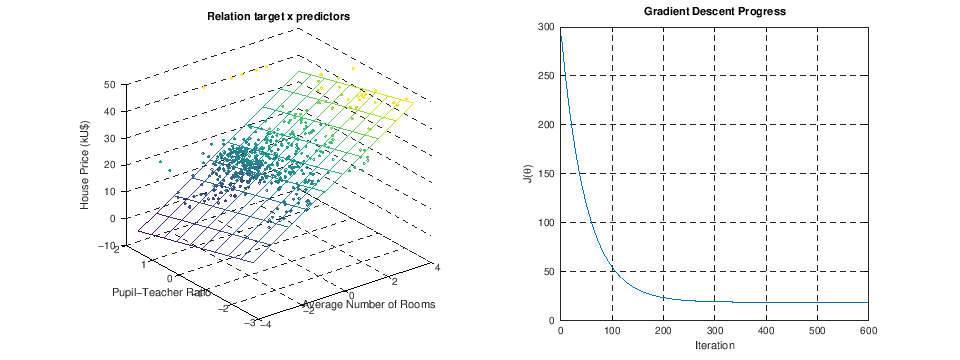

In [15]:
%plot inline -r 100 -w 960 -h 360

subplot(1, 2, 1);
scatter3(X_hyps(:, 2), X_hyps(:, 3), y, [], y(:), 'o');
hold on;
mesh(xx, yy, zz, 'facecolor', 'none');
title('Relation target x predictors');
xlabel('Average Number of Rooms');
ylabel('Pupil-Teacher Ratio');
zlabel('House Price (kU$)');
grid on;
set(gca, 'GridLineStyle', '--');

subplot(1, 2, 2);
plot(1:size(J_history, 1), J_history);
title('Gradient Descent Progress');
xlabel('Iteration');
ylabel('J(\theta)');
grid on;
set(gca, 'GridLineStyle', '--');

To verify convergence to normal equation solution, we compare the error histograms.

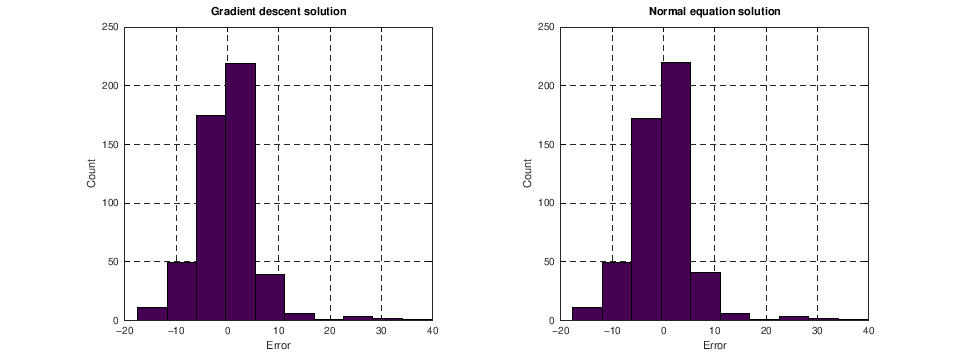

In [16]:
subplot(1, 2, 1);
hist(y-y_pred);
title('Gradient descent solution');
xlabel('Error');
ylabel('Count');
grid on;
set(gca, 'GridLineStyle', '--');

subplot(1, 2, 2);
hist(y-y_norm);
title('Normal equation solution');
xlabel('Error');
ylabel('Count');
grid on;
set(gca, 'GridLineStyle', '--');

## Exercise

Modify this notebook for including regularization parameters to the regression. Consider $L^{1}$-norm (LASSO) and $L^{2}$-norm (Ridge) regularizations.